# Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_curve
import json
import numpy as np
import sklearn.preprocessing as pre
%matplotlib inline

data_dir = '../../data/processed/'

In [2]:
def get(train_size, val_size, test_size):
    '''
    remember to adjust your file path
    read the data for use
    '''

    with open(data_dir+'label.json') as f:
        label = json.load(f)
    with open(data_dir+'non_sequential_features.json') as f:
        non_sequential_features = json.load(f)
    with open(data_dir+'padded_sequential_features_3.json') as f:
        sequential_features = json.load(f)

    label_size = len(label)
    train_size = int(train_size*label_size)
    val_size = int(val_size*label_size)
    test_size = int(test_size*label_size)
    
    feature1 = np.array([sequential_features[key]
                         for key in sequential_features.keys()])
    feature2 = np.array([non_sequential_features[key]
                         for key in non_sequential_features.keys()])
    label = np.array([label[key] for key in label.keys()])
    feature1_benign = feature1[label == 1]
    feature2_benign = feature2[label == 1]
    label_benign = label[label == 1]

    idx = np.arange(len(label))
    np.random.shuffle(idx)

    idx_train = idx[:train_size]
    idx_val = idx[train_size:train_size+val_size]
    idx_test = idx[train_size+val_size:train_size+val_size+test_size]

    train_seq, val_seq, test_seq = feature1[idx_train], feature1[idx_val], feature1[idx_test]
    train_non, val_non, test_non = feature2[idx_train], feature2[idx_val], feature2[idx_test]
    train_Y, val_Y, test_Y = label[idx_train], label[idx_val], label[idx_test]

    return (train_seq, train_non, train_Y), (val_seq, val_non, val_Y), (test_seq, test_non, test_Y)

In [3]:
# read the data and split into train, validation and test

train, val, test = get(train_size=0.85, val_size=0.05, test_size=0.1)

In [6]:
def get_KS(y_prob,y_true):
    ''' 
    return the best threshold, maximum ks
    
    '''
    from sklearn.metrics import roc_curve
    fpr,tpr,threshold=roc_curve(y_true,y_prob)
    ks=(tpr-fpr)
    max_=np.argmax(ks)
    
    return threshold[max_],np.max(ks)

# KNN

# CNN+LSTM

In [8]:
train_seq, train_non, train_Y = train

In [10]:
train_seq[2,:,4]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [12]:
def non_onehot(data,size1):
    '''
    change the one-hot into label_encoder.
    '''
    return data

In [14]:
t=pre.OneHotEncoder()

In [15]:
train_Y=(t.fit_transform(train_Y[:,np.newaxis])).todense()

/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [16]:
train_seq=non_onehot(train_seq,14)

In [17]:
train_seq.shape,train_non.shape,train_Y.shape

((60000, 60, 18), (60000, 14), (60000, 2))

In [18]:
val_seq,val_non,val_Y=val
val_seq=non_onehot(val_seq,14)
val_Y=(t.fit_transform(val_Y[:,np.newaxis])).todense()
val_seq.shape,val_non.shape,val_Y.shape

/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


((5000, 60, 18), (5000, 14), (5000, 2))

In [19]:
import tensorflow.keras as keras
from pyts.image import GramianAngularField as GAF
from pyts.image import MarkovTransitionField as MTF

In [20]:
from tensorflow.keras import metrics

In [21]:
from sklearn.metrics import auc, roc_curve

In [22]:
class CNN_LSTM:
    def __init__(self,data,data_non_seq,features,bins_list,size,strategy,label):
        '''
        data: training data, sequential data
        data_non_seq: training data, non_sequential data
        bins_list: the bins you want for different features when generating MTF
        features: the number of features you feed into the model
        size: fig_size for MTF and GAF ( not apply in this project since we only use LSTM)
        strategy: the strategy for generating MTF, usually use normal
        label: the training label, Y
        '''    
        self.size=size
        self.strategy=strategy
        self.true_features=features
        self.bins_list=bins_list
        self.label=label
        
        tp_shape=data_non_seq.shape
        self.non_seq_shape=(tp_shape[1],)
        
        testing=self.transform_used(100,data,data_non_seq,label=self.label)
        tp_shape=(next(testing)[0]).shape
        self.img_shape=(tp_shape[1],tp_shape[2],tp_shape[3])
        
        
        self.CNN=self.CNN_()
        self.LSTM=self.LSTM_()
        self.non_sequential_NN=self.non_sequential_NN_()
        self.complete_model=self.whole_model()
        
#         optimizer=keras.optimizers.Adam(lr=0.0002,beta_1=0.5)
        optimizer=keras.optimizers.Adagrad(learning_rate=0.0001)
        self.CNN.trainable=True
        self.LSTM.trainable=True
        self.non_sequential_NN.trainable=True
        self.complete_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])
        
        self.metrics=[0,0,0,0,0]
        
    
    def data_mtf(self,X,bins):
        mtf=MTF(image_size=self.size,n_bins=bins,strategy=self.strategy)
        mtf.fit(X)
        return mtf
        
    def data_gaf(self,X):
        gaf=GAF(image_size=self.size)
        gaf.fit(X)
        return gaf
    
    def transform_used(self,batch_size,data_used,data_non,label,\
                       random_or_not=True,train=True):
        '''
        data_used: sequentila data 
        data_non: non_sequential data
        label: label for training
        random_or_not:False, not random, True, will shuffle it. 
        this will be important when you are not training data. Since we will sometimes use this 
        function generating data for prediction. And the label will then can be randomly assigned
        
        output: MTF&GAF graph data; non_sequential data, time-series data for LSTM, label 
        '''
        frame_minu=np.concatenate((np.ones(shape=(batch_size,1))*(1e-10),np.zeros(shape=(batch_size,data_used.shape[1]-1))),axis=-1)
        frame_minu_last=np.concatenate((np.ones(shape=(len(data_used)%batch_size,1))*(1e-10),np.zeros(shape=(len(data_used)%batch_size,data_used.shape[1]-1))),axis=-1)
        if len(frame_minu_last)==0:
            frame_minu_last=frame_minu

        X_train=np.concatenate([data_used[:,:,0][:,:,np.newaxis],data_used[:,:,14:]],axis=-1)
        if train:
            self.fitting_frame=[]
            for i in range(self.true_features):
                self.fitting_frame.append((self.data_mtf(X_train[:,:,i],bins=self.bins_list[i]),self.data_gaf(X_train[:,:,i])))
        else:
            pass
        fitting_frame=self.fitting_frame

#         for epoch in range(epochs):
        whole=len(X_train)//batch_size+(len(X_train)%batch_size!=0)
        total_loss=0
        
        idx=np.arange(len(data_used))
        if random_or_not:
            np.random.shuffle(idx)
        else:
            pass
        
        for step in range(whole):
            if step<(whole-1):
                frame_minu_=frame_minu
            else:
                if (whole%batch_size>0):
                    frame_minu_=frame_minu_last
                else:
                    frame_minu_=frame_minu

            imgs=X_train[idx[step*batch_size:(step+1)*batch_size]]
#                 get the whole transformed_data
            transformed_data=[]
            for i in range(self.true_features):            
                transformed_data.append(fitting_frame[i][0].transform(frame_minu_+imgs[:,:,i]))
                transformed_data.append(fitting_frame[i][1].transform(frame_minu_+imgs[:,:,i]))            
            non_seq_data=data_non[idx[step*batch_size:(step+1)*batch_size]]
            lstm_data=X_train[idx[step*batch_size:(step+1)*batch_size]]
            return_label=label[idx[step*batch_size:(step+1)*batch_size]]
            
            yield((np.concatenate([i[:,:,:,np.newaxis] for i in transformed_data],axis=-1)),non_seq_data,lstm_data,return_label)

    def CNN_(self):
        '''
        keras model. CNN
        '''
        dropout=0.5
        model=keras.Sequential()
        model.add(keras.layers.Conv2D(filters=64,kernel_size=4,strides=2,padding='same',activation='relu',\
                                     input_shape=self.img_shape))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
#         model.add(keras.layers.MaxPooling2D())
        model.add(keras.layers.AveragePooling2D(pool_size=4,strides=(2,2),padding='same'))
        
        model.add(keras.layers.Conv2D(filters=32,kernel_size=2,strides=2,padding='same',activation='relu'))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
#         model.add(keras.layers.MaxPooling2D())
        model.add(keras.layers.AveragePooling2D(pool_size=4,strides=(2,2),padding='same'))
        
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(64,activation='relu'))
        
        img=keras.Input(shape=self.img_shape)
        val=model(img)
        
        model.summary()
        return keras.Model(img,val)
        
    def LSTM_(self):
        '''
        LSTM keras model, try to handel original data     
        adding 1-D convolution first
        
        
        '''
        from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
        
        timesteps=60
        n_features=self.true_features
        model=keras.Sequential()
        model.add(keras.layers.Conv1D(filters=64,kernel_size=4,padding='same',activation='relu',strides=1\
                                     ,input_shape=(timesteps,n_features)))
        
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation="tanh",\
                                                                return_sequences=True)))
#         model.add(Bidirectional(keras.layers.LSTM(128, activation="tanh", return_sequences=True)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
                  
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(32, activation="tanh", return_sequences=False)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units=64,activation="relu"))
        
        inp=keras.Input(shape=(timesteps,n_features))
        out=model(inp)
        model.summary()
        return keras.Model(inp,out)
    
    
        
        
    def non_sequential_NN_(self):
        '''
        Neural network for NN
        '''
        dropout=0.5
        n_features=self.non_seq_shape
        model=keras.Sequential()
        model.add(keras.layers.Dense(128,activation="relu",input_shape=n_features))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
        
        model.add(keras.layers.Dense(64,activation="relu"))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
        
#         model.add(keras.layers.Dense(64,activation="relu"))
        
        inp=keras.Input(shape=n_features)
        out=model(inp)
        model.summary()
        return keras.Model(inp,out)
        
        
    def whole_model(self):
        '''
        putting all models together
        '''
        dropout=0.5
        seq_inp=keras.Input(shape=self.img_shape)
        non_inp=keras.Input(shape=self.non_seq_shape)
#         LSTM_inp=keras.Input(shape=(60,self.true_features))
        
        seq=self.CNN(seq_inp)
        non_seq=self.non_sequential_NN(non_inp)
#         rnn=self.LSTM(LSTM_inp)
        
#         model=keras.Sequential()
        concat_=keras.layers.concatenate([seq,non_seq])
#         concat_=non_seq
        flat=keras.layers.Flatten()(concat_)
        act1=keras.layers.Dense(256,activation="relu")(flat)
        norm1=keras.layers.BatchNormalization()(act1)
        drop1=keras.layers.Dropout(dropout)(norm1)
        
#         act2=keras.layers.Dense(64,activation="relu")(drop1)
#         drop2=keras.layers.Dropout(dropout)(act2)
        
        act3=keras.layers.Dense(16,activation="relu")(drop1)
        norm3=keras.layers.BatchNormalization()(act3)
        drop4=keras.layers.Dropout(dropout)(norm3)
        
        out=keras.layers.Dense(2,activation="softmax")(drop4)
        
        model=keras.Model(inputs=[seq_inp,non_inp],outputs=out)
        model.summary()
        return model
    
    def training(self,epochs,batch_size,show_epoch,data,data_non,label,\
                 val_seq,val_non,val_Y,path=None):
        
        data_used=data
        for epoch in range(epochs):
            gener=self.transform_used(batch_size,data,data_non,label)
            whole=len(data_used)//batch_size+(len(data_used)%batch_size!=0)
            total_loss=0
            mean_accuracy=0

            for step in range(whole):
                imgs,non_seq_data,lstm_data,label_batch=next(gener)
                loss=self.complete_model.train_on_batch([imgs,non_seq_data,lstm_data],label_batch)
#                 self.complete_model.train_on_batch()
#                 total_loss+=(loss.loss[0]/whole)
#                 mean_accuracy+=(loss.loss[1]/whole)

            if epoch%show_epoch==0:
                
                predict_prob,predict=self.model_predict(model=self.complete_model,data_seq=val_seq,data_non=val_non,\
                                               batch_size=50)
                val_acc=np.mean(predict==val_Y[:,1])
                _,val_KS=get_KS(predict_prob[:,1],val_Y[:,1])
                fpr,tpr,threshold=roc_curve(val_Y[:,1],predict_prob[:,1])
                val_auc=auc(fpr,tpr)
                self.saver(name="MTF_NON_show1_epoch"+str(epoch)+".h5",model=self.complete_model,\
                          metrics=[val_KS,val_auc])
                
#                 print("training on epoch: {}, loss is {}".format(epoch,total_loss))
#                 print("training on epoch: {}, accuracy is {}".format(epoch,mean_accuracy))
                print("training on epoch: {}, validation accuracy is {}".format(epoch,val_acc))
                print("training on epoch: {}, validation KS is {}".format(epoch,val_KS))
                print("training on epoch: {}, validation AUC is {}".format(epoch,val_auc))
                print("balance_status of validation set have {} of ones in val".format(np.sum(val_Y[:,1])/len(val_Y)))
                
                fpr, tpr, threshold = roc_curve(val_Y[:,1],predict_prob[:,1])                
                plt.title('ROC')
                plt.plot(fpr, tpr, 'b')
                plt.legend(loc = 'lower right')
                plt.plot([0, 1], [0, 1],'r--')
                plt.xlim([0, 1])
                plt.ylim([0, 1])
                plt.ylabel('True Positive Rate')
                plt.xlabel('False Positive Rate')
                plt.show()
                
                
#                 a=self.sample_images(X=X,epoch=epoch)
                print("------------generate form-------------------------------------------")
                print("--------------------------------------------------------------------")
                
        
    def saver(self,name,model,metrics=None):
        if metrics==None:
            model.save(name)
        else:
            if (metrics[0]>self.metrics[0]) and (metrics[1]>self.metrics[1]):
                model.save(name)
                self.metrics=metrics
                print("-----------------------saving models------------------------------")
            else:
                pass


    def model_predict(self,model,data_seq,data_non,batch_size):
        '''
        return prediction for using batch_size
        '''
        fake_label=np.arange(len(data_non))
        k=self.transform_used(batch_size,data_used=data_seq,data_non=data_non,label=fake_label,\
                             random_or_not=False,train=False)
        store=[]
        for i in range(len(data_seq)//batch_size+(len(data_seq)%batch_size!=0)):

            test_dataset=next(k)
            d0=test_dataset[0]
            d1=test_dataset[1]
#             d2=test_dataset[2]
#                     pay attention to the d1 d2 here. you need to adjust it
            test_predict_prob=model.predict([d0,d1])
            store.append(test_predict_prob)
        store=np.concatenate(store)
        prob=store
        prediction=np.argmax(prob,axis=-1)
        return prob,prediction        
        
        
        
        

In [23]:
bins_list=[10,10,10,10,10]
data=train_seq
data_non_seq=train_non
features=5
size=48
strategy="uniform"
label=train_Y
test_model=CNN_LSTM(data=data,data_non_seq=data_non_seq,features=features,bins_list=bins_list,\
                    size=size,strategy=strategy,label=train_Y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        10304     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 32)          1

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 64)            1344      
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           66048     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 60, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)               

In [24]:
k=test_model.transform_used(100,data_used=data,data_non=data_non_seq,label=train_Y)

In [25]:
a,b,c,d=next(k)

In [26]:
a.shape,b.shape,c.shape,d.shape

((100, 48, 48, 10), (100, 14), (100, 60, 5), (100, 2))

No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 0, validation accuracy is 0.30342656
training on epoch: 0, validation KS is 0.010928255838150047
training on epoch: 0, validation AUC is 0.47973057678001774
balance_status of validation set have 0.0674 of ones in val


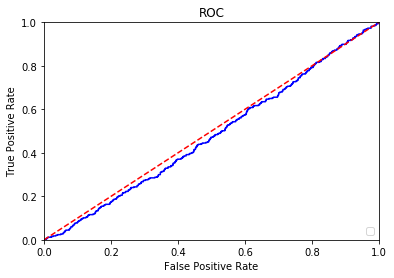

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 2, validation accuracy is 0.16585976
training on epoch: 2, validation KS is 0.011707163725292347
training on epoch: 2, validation AUC is 0.4805174392003212
balance_status of validation set have 0.0674 of ones in val


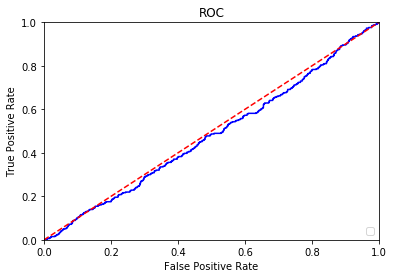

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 4, validation accuracy is 0.1660328
training on epoch: 4, validation KS is 0.021147603680976124
training on epoch: 4, validation AUC is 0.4774065803716485
balance_status of validation set have 0.0674 of ones in val


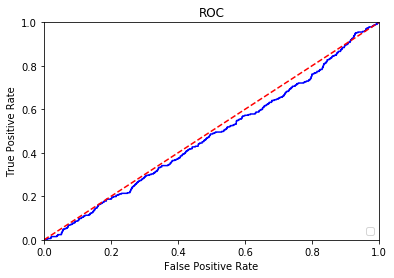

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 6, validation accuracy is 0.16153376
training on epoch: 6, validation KS is 0.01771633625657132
training on epoch: 6, validation AUC is 0.47615040049483565
balance_status of validation set have 0.0674 of ones in val


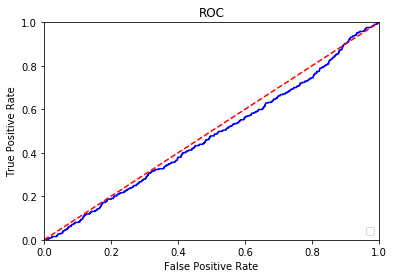

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 8, validation accuracy is 0.16482152
training on epoch: 8, validation KS is 0.0201803324485772
training on epoch: 8, validation AUC is 0.47721630793843317
balance_status of validation set have 0.0674 of ones in val


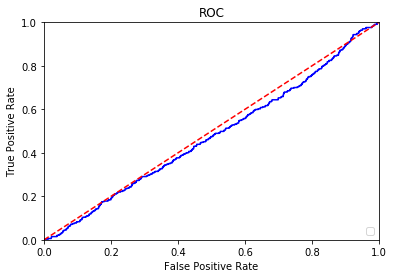

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 10, validation accuracy is 0.16568672
training on epoch: 10, validation KS is 0.019077515971111625
training on epoch: 10, validation AUC is 0.47797676130864164
balance_status of validation set have 0.0674 of ones in val


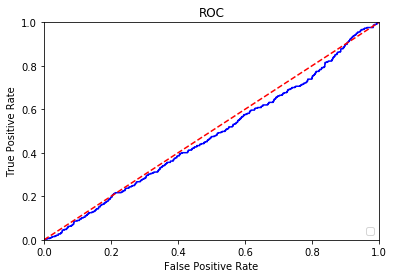

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 12, validation accuracy is 0.16845536
training on epoch: 12, validation KS is 0.023082146145774085
training on epoch: 12, validation AUC is 0.47946139537784355
balance_status of validation set have 0.0674 of ones in val


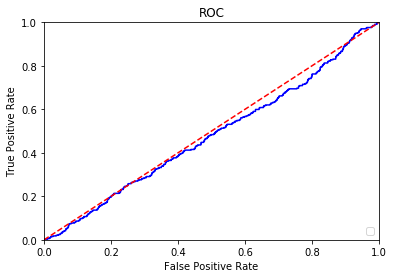

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 14, validation accuracy is 0.16724408
training on epoch: 14, validation KS is 0.0199703327731221
training on epoch: 14, validation AUC is 0.4779831249351706
balance_status of validation set have 0.0674 of ones in val


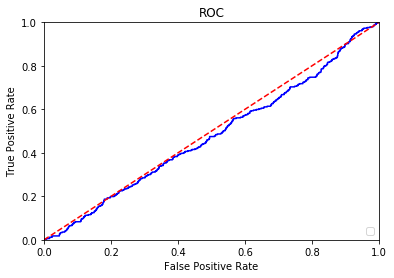

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 16, validation accuracy is 0.16707104
training on epoch: 16, validation KS is 0.025331688123754748
training on epoch: 16, validation AUC is 0.47964912236044727
balance_status of validation set have 0.0674 of ones in val


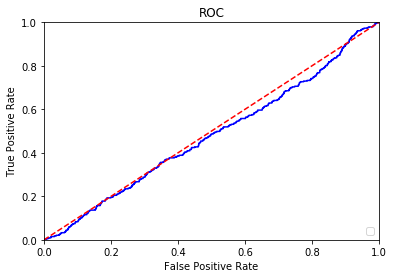

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 18, validation accuracy is 0.17433872
training on epoch: 18, validation KS is 0.022149874859284324
training on epoch: 18, validation AUC is 0.4789182598535984
balance_status of validation set have 0.0674 of ones in val


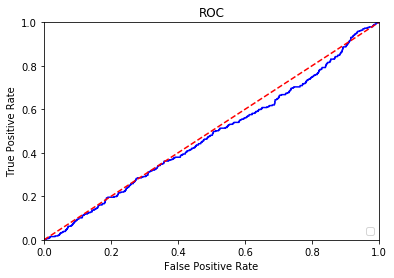

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 20, validation accuracy is 0.17243528
training on epoch: 20, validation KS is 0.022758237555451033
training on epoch: 20, validation AUC is 0.478394851571593
balance_status of validation set have 0.0674 of ones in val


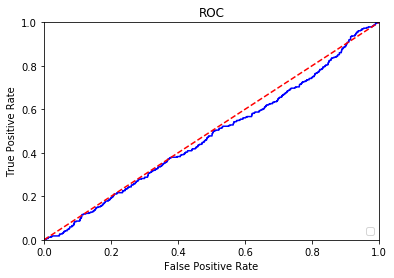

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 22, validation accuracy is 0.16845536
training on epoch: 22, validation KS is 0.0199703327731221
training on epoch: 22, validation AUC is 0.4793411228364465
balance_status of validation set have 0.0674 of ones in val


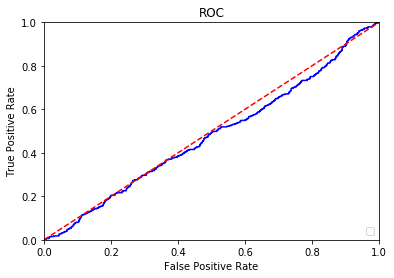

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 24, validation accuracy is 0.1746848
training on epoch: 24, validation KS is 0.02143651232539001
training on epoch: 24, validation AUC is 0.48047225745196576
balance_status of validation set have 0.0674 of ones in val


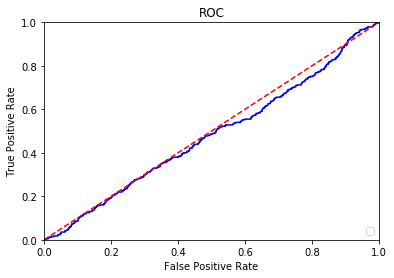

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 26, validation accuracy is 0.17693432
training on epoch: 26, validation KS is 0.01896360705624356
training on epoch: 26, validation AUC is 0.4781479428622701
balance_status of validation set have 0.0674 of ones in val


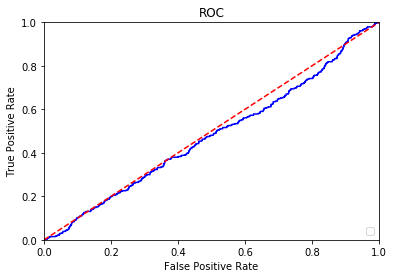

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 28, validation accuracy is 0.18022208
training on epoch: 28, validation KS is 0.01950642439916228
training on epoch: 28, validation AUC is 0.4809441203590867
balance_status of validation set have 0.0674 of ones in val


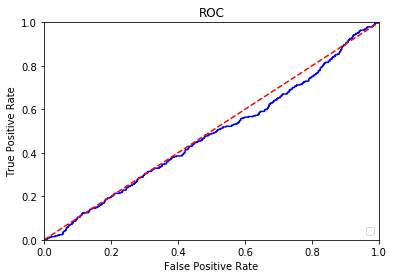

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 30, validation accuracy is 0.18264464
training on epoch: 30, validation KS is 0.0189680615948139
training on epoch: 30, validation AUC is 0.4797681221765385
balance_status of validation set have 0.0674 of ones in val


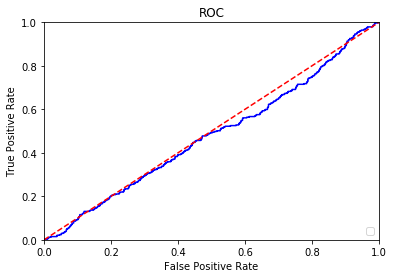

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 32, validation accuracy is 0.179876
training on epoch: 32, validation KS is 0.015431794332681492
training on epoch: 32, validation AUC is 0.4830848443234224
balance_status of validation set have 0.0674 of ones in val


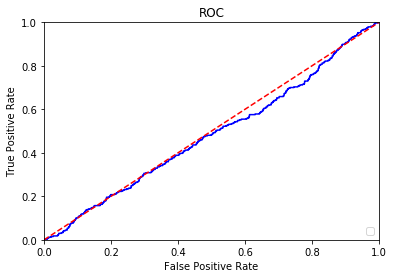

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 34, validation accuracy is 0.18627848
training on epoch: 34, validation KS is 0.019361970076955393
training on epoch: 34, validation AUC is 0.4836792070412255
balance_status of validation set have 0.0674 of ones in val


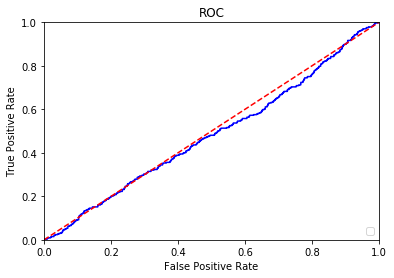

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 36, validation accuracy is 0.18800888
training on epoch: 36, validation KS is 0.01850415322085408
training on epoch: 36, validation AUC is 0.4839833883893089
balance_status of validation set have 0.0674 of ones in val


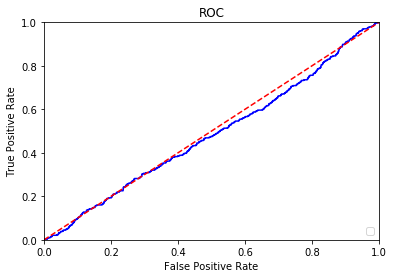

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 38, validation accuracy is 0.19077752
training on epoch: 38, validation KS is 0.019217515754748393
training on epoch: 38, validation AUC is 0.48507315943239
balance_status of validation set have 0.0674 of ones in val


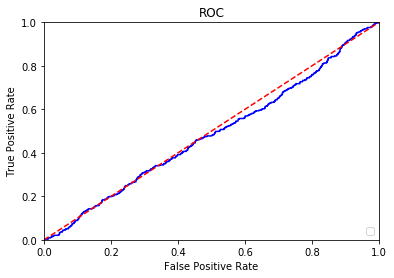

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 40, validation accuracy is 0.1876628
training on epoch: 40, validation KS is 0.023502145496684168
training on epoch: 40, validation AUC is 0.48600065799898307
balance_status of validation set have 0.0674 of ones in val


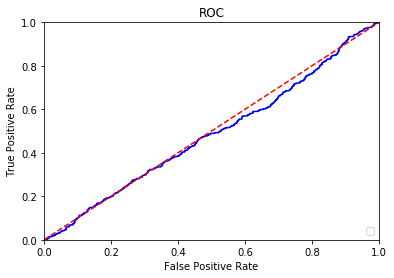

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 42, validation accuracy is 0.1980452
training on epoch: 42, validation KS is 0.019681424128708214
training on epoch: 42, validation AUC is 0.4865472935178191
balance_status of validation set have 0.0674 of ones in val


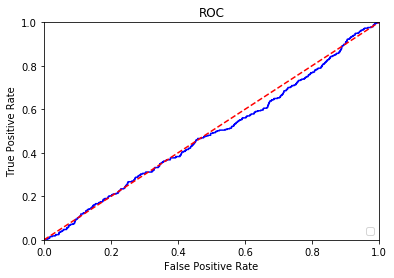

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 44, validation accuracy is 0.19146968
training on epoch: 44, validation KS is 0.027686229939462903
training on epoch: 44, validation AUC is 0.48756833739438776
balance_status of validation set have 0.0674 of ones in val


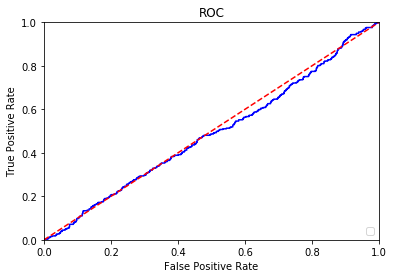

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 46, validation accuracy is 0.2006408
training on epoch: 46, validation KS is 0.022464874372466803
training on epoch: 46, validation AUC is 0.4865161117478273
balance_status of validation set have 0.0674 of ones in val


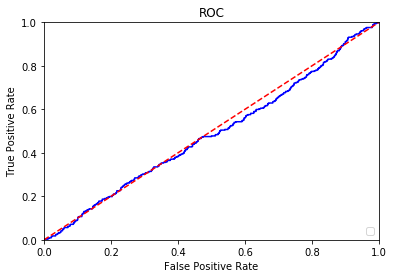

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 48, validation accuracy is 0.19423832
training on epoch: 48, validation KS is 0.021856511676300094
training on epoch: 48, validation AUC is 0.48693611109873747
balance_status of validation set have 0.0674 of ones in val


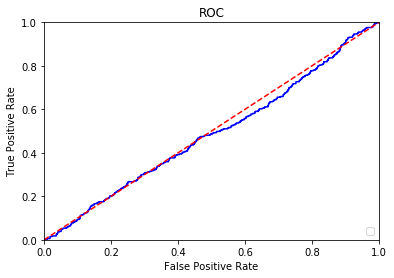

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 50, validation accuracy is 0.19960256
training on epoch: 50, validation KS is 0.019068606893971163
training on epoch: 50, validation AUC is 0.48591188540890434
balance_status of validation set have 0.0674 of ones in val


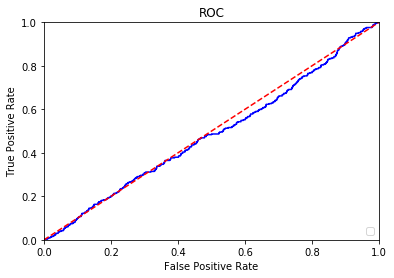

------------generate form-------------------------------------------
--------------------------------------------------------------------


KeyboardInterrupt: 

In [27]:
test_model.training(epochs=100,batch_size=1000,show_epoch=2,data=data,data_non=data_non_seq,label=train_Y\
                   ,val_seq=val_seq,val_non=val_non,val_Y=val_Y)

In [28]:
test_seq,test_non,test_Y=test
test_seq=non_onehot(test_seq,14)
test_Y=(t.fit_transform(test_Y[:,np.newaxis])).todense()
test_seq.shape,test_non.shape,test_Y.shape

/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


((20000, 60, 18), (20000, 14), (20000, 2))

In [29]:
# YY_prob.shape

In [30]:
# YY_prob=test_model.non_sequential_NN.predict(test_non)
# np.sum(YY_prob,axis=-1)

In [31]:
# np.sum(YY_prob)

In [32]:
73338.695

73338.695

In [33]:
# YL_prob=test_model.LSTM.predict(test_seq)
# np.sum(YL_prob,axis=-1)

In [34]:
# np.sum(YL_prob)

In [35]:
k = test_model.transform_used(500, data_used=test_seq, data_non=test_non, label=train_Y,
                              random_or_not=False, train=False)
store = []
for i in range(len(test_seq)//500+(len(test_seq) % 500 != 0)):
    test_dataset = next(k)
    d0 = test_dataset[0]
    d1 = test_dataset[1]
#     d2=test_dataset[2]
    test_predict_prob = test_model.complete_model.predict([d0, d1])
    store.append(test_predict_prob)
store = np.concatenate(store, axis=0)
test_predict_prob = store
test_predict = np.argmax(test_predict_prob, axis=-1)
acc = np.mean(test_predict == test_Y[:, 1])
test_ks = get_KS(test_predict_prob[:, 1], test_Y[:, 1])
acc, test_ks

(0.20143628, (0.6174718, 0.035051876236247614))

In [39]:
fpr,tpr,threshold=roc_curve(test_Y[:,1],test_predict_prob[:,1])
val_auc=auc(fpr,tpr)
val_auc

0.5074331410757363

No handles with labels found to put in legend.


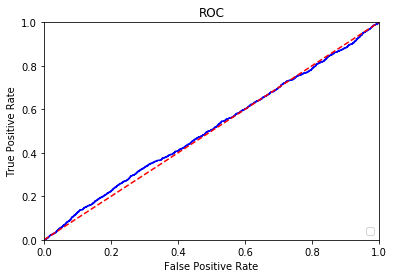

In [36]:
fpr, tpr, threshold = roc_curve(test_Y[:,1],test_predict_prob[:,1])                
plt.title('ROC')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
